<a href="https://colab.research.google.com/github/JoonghoonChoi/AI_01_Projects/blob/main/Section_4/AI_01_%EC%B5%9C%EC%A4%91%ED%9B%88_Project_Section_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1aRY_GKu9XqXbkyIQ_tNS2zEqdn3n38sV?hl=ko#scrollTo=Ix7dTqVC7eVX)
# Supervised Learning for sentiment analysis
라벨이 있는 데이터셋을 사용한 감성 분류 모델링

In [889]:
import random
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
from joblib import Parallel, delayed
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud

import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras import regularizers


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Set seed
random.seed(34)
np.random.seed(34)
os.environ['PYTHONHASHSEED'] = str(34)
os.environ['TF_DETERMINISTIC_OPS'] = str(34)
tf.random.set_seed(34)

## 1. Text Sentiment Data Gathering


### ~Stanford Setiment Treebank Dataset~
- ~영화 12,000여 개 영화 리뷰 데이터를 기반으로 한 200,000개 이상의 Parse 데이터(manually labelled)~
- ~감성 분석에서 중요하게 발표되었던 데이터셋이며, 새로운 모델이 발표되기 전 테스트 용으로 사용되기도 함~
- ~이번 프로젝트에서는 뉴스 헤드라인 분석을 목표로 할 것이고, 약 10만개의 뉴스 데이터를 찾았기 때문에 해당 리뷰데이터는 사용하지 않음~

~*Reference:*<br>
https://nlp.stanford.edu/sentiment/code.html
<br>https://towardsdatascience.com/the-stanford-sentiment-treebank-sst-studying-sentiment-analysis-using-nlp-e1a4cad03065~


- Description

    Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank
    Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Christopher Manning, Andrew Ng and Christopher Potts<br><br>
    Conference on Empirical Methods in Natural Language Processing (EMNLP 2013)
    sentiment_labels.txt contains all phrase ids and the corresponding sentiment labels, separated by a vertical line.<br>
    ***Note that you can recover the 5 classes by mapping the positivity probability using the following cut-offs:<br>
    (0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)<br>
    for very negative, negative, neutral, positive, very positive, respectively.***
    <br>Please note that phrase ids and sentence ids are not the same.
    <br><br>
    After converting all of the text to lowercase and removing non-English sentences, they use the Stanford Parser to split sentences into phrases, ending up with a total of 215,154 phrases.

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/sample_data/sentiment_text_dataset/StanfordSentimentTreebank/stanfordSentimentTreebank.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/sample_data/sentiment_text_dataset/StanfordSentimentTreebank/stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTree

In [ ]:
phrase_data = pd.read_csv('/content/stanfordSentimentTreebank/sentiment_labels.txt', delimiter='|')
id = pd.read_csv('/content/stanfordSentimentTreebank/dictionary.txt', delimiter='|', header=None).sort_values(1)

In [ ]:
phrase_data['phrase'] = id[0]
phrase_data.drop(columns = 'phrase ids', inplace=True)

In [ ]:
phrase_data.head()

,sentiment values,phrase
0,0.50000,!
1,0.50000,! '
2,0.44444,! ''
3,0.50000,! Alas
4,0.42708,! Brilliant


In [ ]:
phrase_data.tail()

,sentiment values,phrase
239227,0.36111,zoning ordinances to protect your community fr...
239228,0.38889,zzzzzzzzz
239229,0.33333,élan
239230,0.88889,É
239231,0.50000,É um passatempo descompromissado


In [ ]:
phrase_data.isnull().sum()

sentiment values    0
phrase              0
dtype: int64

In [ ]:
def sentiment_calss(row):
    '''
    sentiment 
    '''
    if row['sentiment values'] <= 0.2:
        val = 'very negative'
   
    elif row['sentiment values'] > 0.2 and row['sentiment values'] <= 0.4:
        val = 'negative'
   
    elif row['sentiment values'] > 0.4 and row['sentiment values'] <= 0.6:
        val = 'neutral'
   
    elif row['sentiment values'] > 0.6 and row['sentiment values'] <= 0.8:
        val = 'positive'
   
    elif row['sentiment values'] > 0.8:
        val = 'very positive'
    
    return val

In [ ]:
phrase_data['class'] = phrase_data.apply(lambda x: sentiment_calss(x), axis=1)

In [ ]:
print(phrase_data['class'].value_counts() / len(phrase_data['class']))
print('\nShape is', phrase_data.shape)

neutral          0.499302
positive         0.209621
negative         0.179859
very positive    0.063767
very negative    0.047452
Name: class, dtype: float64

Shape is (239232, 3)


### UCI 뉴스 데이터셋<br>
2015-2016년 8개월 동안의 미국 뉴스 93,000여 개 데이터 (topics: economy, microsoft, odbama, palestine)<br>
https://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms#

**VARIABLES OF NEWS DATA**
- IDLink (numeric): Unique identifier of news items 
- Title (string): Title of the news item according to the official media sources 
- **Headline (string): Headline of the news item according to the official media sources**
- Source (string): Original news outlet that published the news item 
- Topic (string): Query topic used to obtain the items in the official media sources 
- PublishDate (timestamp): Date and time of the news items' publication 
- SentimentTitle (numeric): Sentiment score of the text in the news items' title 
- **SentimentHeadline (numeric): Sentiment score of the text in the news items' headline** 
- Facebook (numeric): Final value of the news items' popularity according to the social media source Facebook 
- GooglePlus (numeric): Final value of the news items' popularity according to the social media source Google+ 
- LinkedIn (numeric): Final value of the news items' popularity according to the social media source LinkedIn 

In [ ]:
uci_news_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_data/sentiment_text_dataset/News_sentiment(2015-2016, US)/News_Final.csv')

print(uci_news_data.shape)
uci_news_data.head(3)

(93239, 11)


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1


In [ ]:
uci_news_data.isnull().sum()

IDLink                 0
Title                  0
Headline              15
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

In [ ]:
uci_news_data.dropna(inplace=True)

In [ ]:
# 기사 헤드라인과 sentiment score 특성 사용
# Sentiment score가 1에 가까울수록 positive, -1에 가까울수록 negative

data = uci_news_data[['Headline', 'SentimentHeadline']].reset_index().drop(columns='index')

In [ ]:
data.head(5)

,Headline,SentimentHeadline
0,Obama Lays Wreath at Arlington National Cemete...,-0.053300
1,"Tim Haywood, investment director business-unit...",-0.156386
2,"Nouriel Roubini, NYU professor and chairman at...",0.139754
3,Finland's economy expanded marginally in the t...,0.026064
4,Tourism and public spending continued to boost...,0.141084


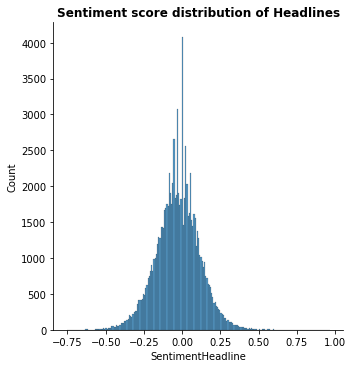


count    92945.000000
mean        -0.027490
std          0.142063
min         -0.755433
25%         -0.114598
50%         -0.026064
75%          0.059868
max          0.964646
Name: SentimentHeadline, dtype: float64


In [ ]:
sns.displot(data['SentimentHeadline'])
plt.title('Sentiment score distribution of Headlines', weight='bold')
plt.show();
print('\n======================================================')
print(data['SentimentHeadline'].describe())

In [ ]:
# 헤드라인 텍스트의 sentimet score에 따라 negative/positive/neutral로 타겟 클래스 설정

def sentiment_calss(row):
    if row['SentimentHeadline'] < -0.1:
        val = 0 # negative
    elif row['SentimentHeadline'] > 0.1:
        val = 2 # positive
    else:
        val = 1 # neutral
    
    return val

In [ ]:
data['Class'] = data.apply(lambda x: sentiment_calss(x), axis=1)
data.head()

,Headline,SentimentHeadline,Class
0,Obama Lays Wreath at Arlington National Cemete...,-0.053300,1
1,"Tim Haywood, investment director business-unit...",-0.156386,0
2,"Nouriel Roubini, NYU professor and chairman at...",0.139754,2
3,Finland's economy expanded marginally in the t...,0.026064,1
4,Tourism and public spending continued to boost...,0.141084,2


In [ ]:
data['Class'].value_counts() / len(data['Class'])

1    0.547862
0    0.284136
2    0.168003
Name: Class, dtype: float64

In [ ]:
print(data[data['Class'] == 0]['Headline'].iloc[150])
print(data[data['Class'] == 0]['Class'].iloc[150], 'negative\n')
print(data[data['Class'] == 1]['Headline'].iloc[50])
print(data[data['Class'] == 1]['Class'].iloc[50], 'neutral\n')
print(data[data['Class'] == 2]['Headline'].iloc[12150])
print(data[data['Class'] == 2]['Class'].iloc[12150], 'positive')

The only signs of life come from a new addition to the neighborhood: Microsoft's flagship retail outlet opened that morning, and now loud music
0 negative

Today Microsoft HoloLens was released for purchase - sort of - for developers, in a kit that's made strictly for those that plan on making software for the device. This version of Microsoft HoloLens is not meant to compete with the other virtual reality headsets being revealed and/or released in the next several weeks. The Oculus Rift, for example, has … Continue reading 
1 neutral

Microsoft developer Saqib Sheikh who lost his eyesight at the age of seven has developed an app to help the visually challenged. The app
2 positive


In [ ]:
data.describe()

,SentimentHeadline,Class
count,92945.000000,92945.000000
mean,-0.027490,0.883867
std,0.142063,0.662311
min,-0.755433,0.000000
25%,-0.114598,0.000000
50%,-0.026064,1.000000
75%,0.059868,1.000000
max,0.964646,2.000000


## 2. 텍스트 전처리

In [ ]:
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load("en_core_web_lg", disable=['tagger', 'parser', 'ner'])
tokenizer = Tokenizer(nlp.vocab)
ps = PorterStemmer()

In [100]:
def text_preprocessing(text):
    text = text.replace(r"[^a-zA-Z0-9]", " ")
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation)) # Remove punctuation [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]
    text = text.strip() # Remove whitespace
    text = re.sub(r'\d+', '', text) # Remove numbers
    return text

# def tokenize_pipe(text):
#     text = text.split()
#     tokens = []
#     for doc in tokenizer.pipe(text):
#         for token in doc:    
#             if (token.is_stop == False) & (token.is_punct == False) & (token.is_space == False):
#                 tokens.append(token.text)    
#     return tokens

# def get_stem(words):
#     stem =[]
#     for word in words:
#         stem.append(ps.stem(word))
#     return stem

def get_lemma(text):
    lemma_lst = [token.lemma_ for token in text
                 if (token.is_alpha==True) & (token.is_stop==False) & (token.is_punct==False) & (token.is_space==False)]
    return lemma_lst


'''
spaCy NLP pipeline speed up
https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-2:-Use-nlp.pipe
'''
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=100):
        preproc_pipe.append(get_lemma(doc))
    return preproc_pipe

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]
    
def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=-1, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(data), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [ ]:
%%time
data['Headline'] = data['Headline'].apply(text_preprocessing)

CPU times: user 977 ms, sys: 13.6 ms, total: 991 ms
Wall time: 988 ms


In [ ]:
%%time
data['tokens'] = preprocess_parallel(data['Headline'], chunksize=3000)

CPU times: user 26.9 s, sys: 4.36 s, total: 31.3 s
Wall time: 1h 23min 25s


In [161]:
# 중복 데이터가 있는 것을 확인하고 삭제
print('중복 데이터 수:', data.duplicated(['Headline', 'SentimentHeadline', 'Class']).sum())
data.drop_duplicates(['Headline', 'SentimentHeadline', 'Class'] ,inplace=True)
data.reset_index(drop=['index'], inplace=True)

중복 데이터 수: 6800


### data-clean.pkl save

In [175]:
# csv로 저장 후 읽어올 때 리스트 타입의 데이터가 모두 문자열로 변환되는 문제가 발생
# 데이터프레임 원형을 보존하기 위해 pickle type으로 저장하는게 안전!
# https://stackoverflow.com/questions/49580996/why-do-my-lists-become-strings-after-saving-to-csv-and-re-opening-python
data.to_pickle('data-clean.pkl')
!cp data-clean.pkl "/content/drive/MyDrive"

In [179]:
clean_data = pd.read_pickle('/content/drive/MyDrive/data-clean.pkl')
print(df.shape)
clean_data.head(3)

(86145, 4)


,Headline,SentimentHeadline,Class,tokens
0,obama lays wreath at arlington national cemete...,-0.053300,1,"[obama, lay, wreath, arlington, national, ceme..."
1,tim haywood investment director businessunit h...,-0.156386,0,"[tim, haywood, investment, director, businessu..."
2,nouriel roubini nyu professor and chairman at ...,0.139754,2,"[nouriel, roubini, nyu, professor, chairman, r..."


In [180]:
clean_data.tail(3)

,Headline,SentimentHeadline,Class,tokens
86142,the palestinian government spends nearly mill...,-0.139754,0,"[palestinian, government, spend, nearly, milli..."
86143,palestine youth orchestra prepares for first u...,0.092313,1,"[palestine, youth, orchestra, prepare, uk, tou..."
86144,goldstein the proprietor of the tg travel grou...,0.054554,1,"[goldstein, proprietor, tg, travel, group, llc..."


## 2. 데이터 탐색

In [275]:
all_tokens = [word for tokens in clean_data['tokens'] for word in tokens] # 전체 토큰
vocab = sorted(list(set(all_tokens))) # 중복 토큰 제외하고 카운트
headline_length = clean_data['Headline'].str.split().str.len()
tokens_length = clean_data['tokens'].str.len()
print("Total words:", len(all_tokens))
print("Vocab size:", len(vocab))
print("Max headline words length:", max(headline_length))
print("Max tokens length:", max(tokens_length))

Total words: 1272897
Vocab size: 48632
Max headline words length: 78
Max tokens length: 62


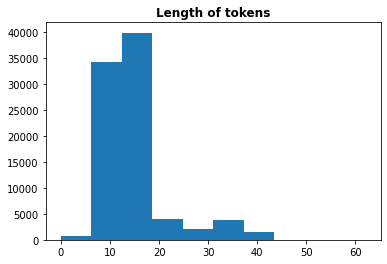

In [213]:
plt.hist(tokens_length)
plt.title('Length of tokens', weight='bold');

In [215]:
def word_count(docs):
    """ 
    Args: docs (series or list): 토큰화된 문서가 들어있는 list
    Returns: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [421]:
wc = word_count(clean_data['tokens'])
wc.head(20)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
4,obama,22004,24679,1.0,0.019388,0.019388,0.255430
13,economy,21543,23837,2.0,0.018727,0.038115,0.250078
3,president,19637,21413,3.0,0.016822,0.054937,0.227953
71,microsoft,16630,19720,4.0,0.015492,0.070429,0.193047
241,say,11101,11968,5.0,0.009402,0.079831,0.128864
2,barack,11848,11948,6.0,0.009386,0.089218,0.137536
116,new,8160,8870,7.0,0.006968,0.096186,0.094724
111,year,7916,8561,8.0,0.006726,0.102912,0.091892
973,economic,8079,8401,9.0,0.006600,0.109512,0.093784
11,state,4939,5329,10.0,0.004187,0.113698,0.057334


In [450]:
def stopwords_add(words):
    # 과거의 뉴스 데이터이기 때문에 당시 많이 나온 단어들의 분포가 높음. 불용어 처리
    new_stopwords = ['obama', 'economy', 'president', 'say', 'microsoft', 'barack', 'obamas']
    return [word for word in words if word not in new_stopwords]

In [451]:
clean_data['tokens'] = clean_data['tokens'].apply(stopwords_add)

In [452]:
def wordcloud(tokens, title):
    word_cloud_dict = Counter(tokens)
    wordcloud = WordCloud().generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, weight='bold', size=12)
    plt.savefig(f'{title}.png', dpi=300)
    plt.show();

In [453]:
all_tokens = [word for tokens in clean_data['tokens'] for word in tokens]
negative_tokens = [word for tokens in clean_data[clean_data['Class'] == 0]['tokens'] for word in tokens]
neutral_tokens = [word for tokens in clean_data[clean_data['Class'] == 1]['tokens'] for word in tokens]
positive_tokens = [word for tokens in clean_data[clean_data['Class'] == 2]['tokens'] for word in tokens]

In [675]:
vocab = sorted(list(set(all_tokens))) # 중복 토큰 제외하고 카운트
len(all_tokens), len(negative_tokens), len(neutral_tokens), len(positive_tokens), len(vocab)

(1155456, 338646, 626690, 190120, 48625)

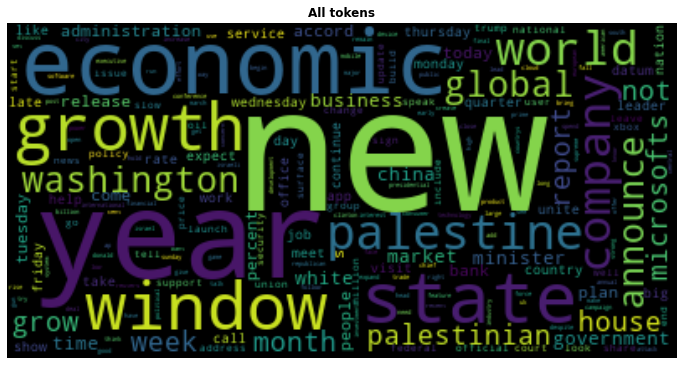

In [455]:
wordcloud(all_tokens, 'All tokens')

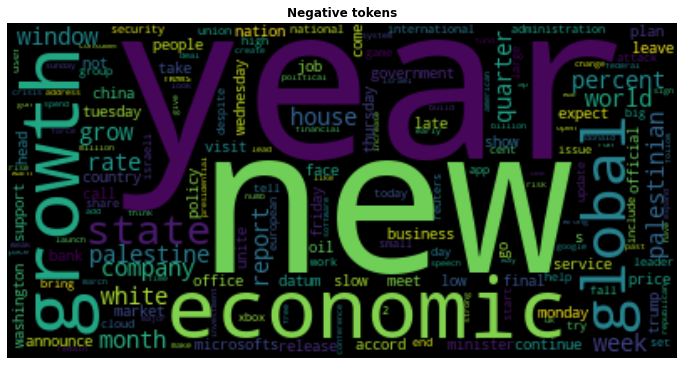

In [456]:
wordcloud(negative_tokens, 'Negative tokens')

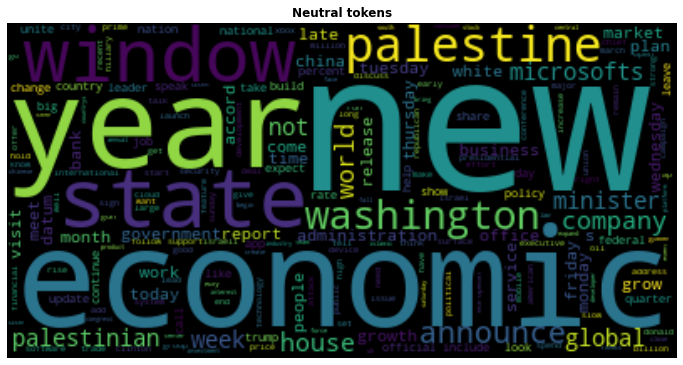

In [457]:
wordcloud(neutral_tokens, 'Neutral tokens')

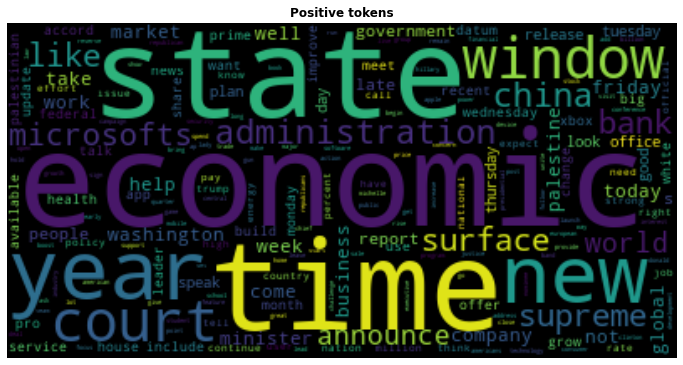

In [459]:
wordcloud(positive_tokens, 'Positive tokens')

## BoW: TfidfVectorizer

In [510]:
headlines = clean_data['Headline'].tolist()
tokens = clean_data['tokens'].tolist()
labels = clean_data['Class'].tolist()

len(headlines), len(tokens), len(labels)

(86145, 86145, 86145)

In [519]:
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = train_test_split(tokens, labels, test_size=0.3, stratify=labels, random_state=34)

len(X_train_tokens), len(X_test_tokens), len(y_train_tokens), len(y_test_tokens)

(60301, 25844, 60301, 25844)

In [520]:
%%time

def identify_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identify_tokenizer,
                        stop_words='english',
                        lowercase=False)

tfidf_X_train = tfidf.fit_transform(X_train_tokens)
tfidf_X_test = tfidf.transform(X_test_tokens)
# dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 1.27 s, sys: 11.9 ms, total: 1.28 s
Wall time: 1.28 s


In [523]:
tfidf_X_train, tfidf_X_test, tfidf

(<60301x40480 sparse matrix of type '<class 'numpy.float64'>'
 	with 757980 stored elements in Compressed Sparse Row format>,
 <25844x40480 sparse matrix of type '<class 'numpy.float64'>'
 	with 316907 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=False, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words='english', strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=<function identify_tokenizer at 0x7f640a899a70>,
                 use_idf=True, vocabulary=None))

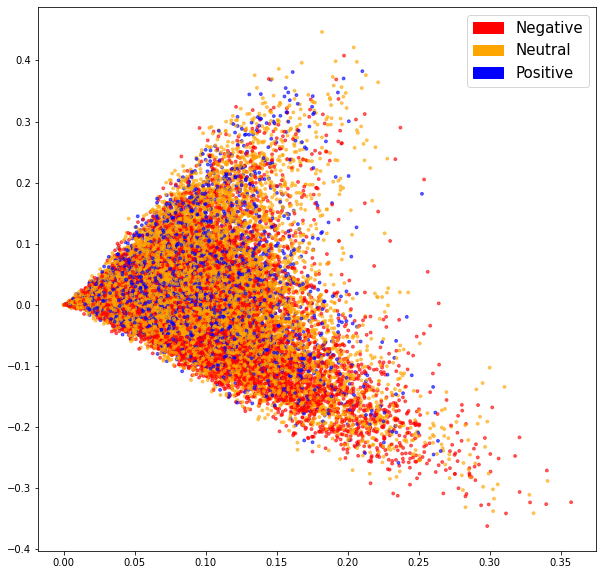

In [666]:
def plot_LSA(data, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(data)
    lsa_scores = lsa.transform(data)
    color_mapper = {label:idx for idx,label in enumerate(set(labels))}
    colors = ['red', 'orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1],
                    s=8, alpha=.6, c=labels, cmap=ListedColormap(colors))
        
        red_patch = mpatches.Patch(color='red', label='Negative')
        orange_patch = mpatches.Patch(color='orange', label='Neutral')
        green_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, orange_patch, green_patch], prop={'size':15})


fig = plt.figure(figsize=(10,10))
plot_LSA(tfidf_X_train, y_train)

### LSA

#### Pipeline: RandomForestClassifier, TruncatedSVD

In [612]:

vect = tfidf
svd = TruncatedSVD(algorithm='randomized', n_iter=5, random_state=34)
rfc = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=34, n_jobs=-1)

vect, svd, rfc

(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=False, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words='english', strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=<function identify_tokenizer at 0x7f640a899a70>,
                 use_idf=True, vocabulary=None),
 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5, random_state=34,
              tol=0.0),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_sam

In [659]:
%%time
lsa_pipe = Pipeline([
                #  ('vect', tfidf),
                 ('svd', svd),
                 ('clf', rfc)
], verbose=True)

lsa_pipe.fit(tfidf_X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing svd, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.4min
CPU times: user 5min 35s, sys: 2.5 s, total: 5min 37s
Wall time: 1min 26s


              precision    recall  f1-score   support

           0       0.32      0.23      0.27      7297
           1       0.55      0.74      0.63     14181
           2       0.18      0.08      0.11      4366

    accuracy                           0.48     25844
   macro avg       0.35      0.35      0.33     25844
weighted avg       0.42      0.48      0.44     25844



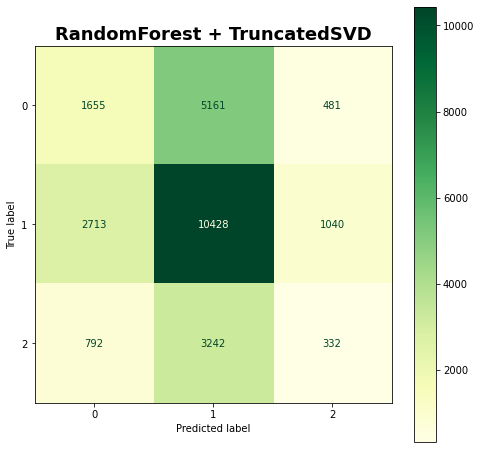

[[ 1655  5161   481]
 [ 2713 10428  1040]
 [  792  3242   332]]


In [661]:
tfidf_y_pred = lsa_pipe.predict(tfidf_X_test)
print(classification_report(y_test, tfidf_y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lsa_pipe, tfidf_X_test, y_test, values_format='.0f', cmap='YlGn', ax=ax)
plt.title('RandomForest + TruncatedSVD', weight='bold', size=18)
plt.savefig('Cofusion-matrix-randomforest+svd.png', dpi=300)
plt.show();

print(confusion_matrix(y_test, tfidf_y_pred))

#### Logistic Regression: baseline model

In [662]:
%%time

lr_tfidf = LogisticRegression(C=30.0,
                               class_weight='balanced',
                               solver='newton-cg',
                               multi_class='multinomial',
                               n_jobs=-1,
                               random_state=34)

lr_tfidf.fit(tfidf_X_train, y_train)

CPU times: user 104 ms, sys: 348 ms, total: 452 ms
Wall time: 12 s


              precision    recall  f1-score   support

           0       0.52      0.58      0.55      7297
           1       0.66      0.56      0.60     14181
           2       0.42      0.54      0.47      4366

    accuracy                           0.56     25844
   macro avg       0.53      0.56      0.54     25844
weighted avg       0.58      0.56      0.57     25844



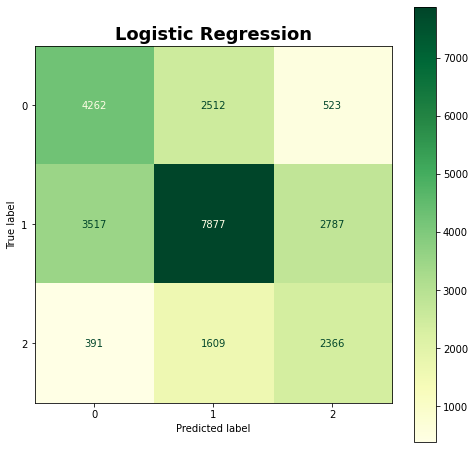

[[4262 2512  523]
 [3517 7877 2787]
 [ 391 1609 2366]]


In [663]:
tfidf_y_pred = lr_tfidf.predict(tfidf_X_test)
print(classification_report(y_test, tfidf_y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lr_tfidf, tfidf_X_test, y_test, values_format='.0f', cmap='YlGn', ax=ax)
plt.title('Logistic Regression', weight='bold', size=18)
plt.savefig('Cofusion-matrix-logisticregression.png', dpi=300)

plt.show();

print(confusion_matrix(y_test, tfidf_y_pred))

## Using LSTM layer

In [713]:
len(X_train), len(y_train), len(X_test), len(y_test)

(60301, 60301, 25844, 25844)

In [790]:
maxlen = max([len(s.split()) for s in X_train])
vocab_size = len(vocab)
embedding_dim = 128
max_features = len(word_index) + 1

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Unique tokens in all documnets:', len(word_index))

Unique tokens in all documnets: 52435


In [831]:
X_train_padding = pad_sequences(X_train_encoded, maxlen=maxlen)
X_test_padding = pad_sequences(X_test_encoded, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train_encoded[0])
print(X_train_padding[0])
print(X_test_encoded[0])
print(X_test_padding[0])

[9, 15, 1791, 62, 15, 14349, 26, 11358, 5644, 56, 614, 2917, 982, 8554]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     9    15  1791    62    15 14349    26 11358
  5644    56   614  2917   982  8554]
[905, 234, 109, 10, 356, 15, 2299, 3789, 2, 1, 3796, 6929, 490, 56, 1, 413, 58, 3, 1, 57, 11, 27, 4]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  905
  234  109   10  356   15 2299 3789    2    1 3796 6929  490   56  

In [890]:
1e-2

0.01

In [898]:
model = Sequential(name='lstmLayerUsing')
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(1024, kernel_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "lstmLayerUsing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 78, 128)           6711808   
_________________________________________________________________
lstm_33 (LSTM)               (None, 1024)              4722688   
_________________________________________________________________
dropout_46 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_47 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)            

In [899]:
X_train_padding.shape, y_train.shape, X_test_padding.shape, y_test.shape

((60301, 78), (60301,), (25844, 78), (25844,))

In [900]:
model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

EPOCHS = 100
batch_size = 500

checkpoint_filepath = '/content/drive/MyDrive/lstmLayerUsing-weights-best.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               verbose=1,
                                               patience=10)


history = model.fit(X_train_padding, y_train,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    validation_data=(X_test_padding, y_test),
                    callbacks=[checkpoint_callback, es_callback],
                    verbose=1)

Epoch 1/100
121/121 [==============================] - 33s 255ms/step - loss: 1.1846 - accuracy: 0.5544 - val_loss: 0.8126 - val_accuracy: 0.6307
Epoch 2/100
121/121 [==============================] - 30s 251ms/step - loss: 0.5537 - accuracy: 0.7717 - val_loss: 0.5141 - val_accuracy: 0.7911
Epoch 3/100
121/121 [==============================] - 30s 251ms/step - loss: 0.2955 - accuracy: 0.8958 - val_loss: 0.5505 - val_accuracy: 0.7932
Epoch 4/100
121/121 [==============================] - 30s 250ms/step - loss: 0.2047 - accuracy: 0.9315 - val_loss: 0.6488 - val_accuracy: 0.7826
Epoch 5/100
121/121 [==============================] - 30s 251ms/step - loss: 0.1458 - accuracy: 0.9517 - val_loss: 0.7348 - val_accuracy: 0.7791
Epoch 6/100
121/121 [==============================] - 30s 250ms/step - loss: 0.1098 - accuracy: 0.9641 - val_loss: 0.8773 - val_accuracy: 0.7834
Epoch 7/100
121/121 [==============================] - 30s 250ms/step - loss: 0.0854 - accuracy: 0.9720 - val_loss: 0.8587 -

In [902]:
loss, acc = model.evaluate(X_test_padding, y_test, batch_size=batch_size)

52/52 [==============================] - 4s 67ms/step - loss: 1.2420 - accuracy: 0.7685


In [873]:
y_train

array([2, 0, 1, ..., 1, 2, 2])

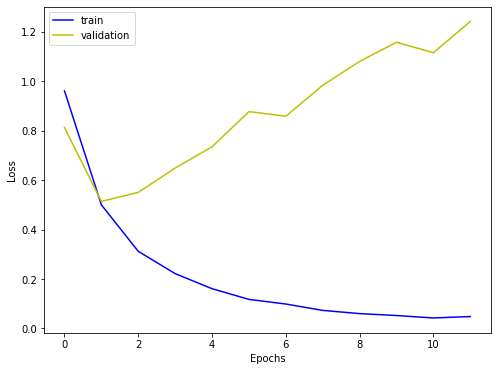

In [903]:
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(history.history['loss'], 'b', label='train')
axes.plot(history.history['val_loss'], 'y', label='validation')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.legend(loc='upper left')
plt.show();

In [907]:
y_pred = model.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7297
           1       0.79      0.79      0.79     14181
           2       0.70      0.73      0.71      4366

    accuracy                           0.77     25844
   macro avg       0.75      0.76      0.75     25844
weighted avg       0.77      0.77      0.77     25844

